# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## 處理數據

首先，我們要下載要使用的數據集。 [數據集](http://ai.stanford.edu/~amaas/data/sentiment/)由Andrew Maas et al 準備好，總共有100,000個imdb上的電影評論。25,000個的影評已被標籤為正面或負面。其餘25,000個影評為測試集（在2個數據集上，影評都正負兩極化）。在餘下的50,000個影評都為額外未標籤的數據（但它們仍有用途）。

我們會在已準備好的樣本開始，即使不需使用整個訓練數據集，也使得訓練過程更快。

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/tmp/.fastai/data/imdb_sample/texts.csv')]

入面只有一個csv檔，先看看它。

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

內含每行一個影評跟標籤（「正面」或「負面」）、文本和標記來判斷是否屬於驗證數據集或是訓練數據集。如果我們無視標記，我們可以以一行碼做一個DataBunch來包含這些數據。

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv', num_workers=0)

執行這行碼後，進行了一會兒的數據處理。圖片（幾乎）可以直接放進去模型因為它們只是一大串像素值界乎於0與1之間。文本是包含字，因為我們無法直接使用數學公式來處理他們。我們需把文字轉換為數字。這有2個程序，首先Tokenization符號化（字符序列轉換為標記（token））然後Numericalization數字化（標記（token）轉化為數值)。`TextDataBunch`已為你把這2個程序完成好。

在鑽研更多解釋前，先把剛轉化好的儲存下來。

In [7]:
data_lm.save()

然後我們可以重啟這個notebook，可以省略以上運行編碼的時間（因為使用完整數據集時會行花時間），把數據加載的結果如下：

In [8]:
data = load_data(path)
#data = TextDataBunch.load(path)

### Tokenization 符號化

第一步的處理是把句子分拆成詞語，或我們稱為標記(tokens)。最簡單方法是以空白來分開文字，但我們也可以用更聰明的方法。

－ 我們可以處理標點符號

－ 有些詞語是由兩個字縮起來的，例如isn't 或者 don't

－ 如包含HTML碼，我們可能需要清理我們的文本

我們可看看以下幾句來看看tokenizer 是怎樣運作的。

In [9]:
data = load_data(path)
#data = TextClasDataBunch.load(path, num_workers=0)
data.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive


為方便閱讀，文本在每100字中會俾切斷。我們可以看到它不只在空格或標點分隔文字：

－ 眾數 "s" 會被組成為同一個token

－ 縮詞被分離，例如"did", "n't"

－ 文本已變成細楷和HTML標籤已被清除

－ 還有特別的符號（tokens) （那些由 xx開頭的），來取代未知的符號（tokens）（如下）或加入了不同的文本字段（我們的例子只有一個)

### Numericalization 數字化

由文字取得符號 (tokens)後，我們把所有用過的文字轉化為數字。我們只保留出現過最少兩次的字，最多保留60,000字（預設值）和以`UNK`符號取代出現次數不足的字。

相對應ids的符號 (tokens)儲存到數據集屬性`vocab`來，內含一個python dictionary 叫`itos`（把數字愈為文字）。

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

然後可以看看有什麼在我們的數據集，我們可以看到已符號化(tokenized)的文字以文字方式顯示：

In [11]:
data.train_ds[0][0]

Text xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot ... which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you ... a feeling you do n't often get from other romantic comedies , however sweet and heart - warming they may be . 
 
  xxmaj alfred xxmaj kralik ( xxmaj james xxmaj stewart ) and xxmaj clara xxmaj xxunk ( xxmaj margaret xxmaj sullavan ) do n't have the most xxunk of first meetings when she arrives in the shop ( xxmaj matusche

但其實內面全都是數字。

In [12]:
data.train_ds[0][0].data[:10]

array([   2,    5,    8,    5, 1015,    5,  174,    5,    8,    5])

### 使用 data block API

比起原始的方法，我們可以使用data block API 來對NLP 增加靈活性。 在之前例子，數據隨機地分成訓練集和驗証集，而不是只是以第三縱來判定是否屬於訓練集，

使用data block API，我們可以手動設定符號化 (tokenize) 和數字化 (numericalize) 的步驟。這可以增加靈活性，如你不想使用fastai 原生的設置，可透過不同的arguments來設置。

In [13]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(num_workers=0))

## 語言模型

注意語言模型會使用大量的GPU，因此需要減少批量 (batchsize)。

In [14]:
bs=48

現在把整個數據集下載。

In [15]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/tmp/.fastai/data/imdb/train'),
 PosixPath('/tmp/.fastai/data/imdb/tmp_lm'),
 PosixPath('/tmp/.fastai/data/imdb/unsup'),
 PosixPath('/tmp/.fastai/data/imdb/README'),
 PosixPath('/tmp/.fastai/data/imdb/tmp_clas'),
 PosixPath('/tmp/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/tmp/.fastai/data/imdb/test')]

In [16]:
(path/'train').ls()

[PosixPath('/tmp/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/tmp/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/tmp/.fastai/data/imdb/train/pos'),
 PosixPath('/tmp/.fastai/data/imdb/train/neg')]

訓練集和測試集的影評都是跟著imagenet的架構。唯一分別為多了個包含未標籤數據的資料夾`unsup`在`train` 和`test`資料夾之上。

我們不是要由零起訓練一個影評分別器 (classifier)。像在電腦視覺中，我們會使用一個已在大量數據（一個已整理的維基百科 [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset) 上訓練的模型。這個模型已訓練到可以預測下個出現的字，輸入為預測字前的幾個字。它有個遞歸神經網絡 (recurrent) 架構。每次看到一個新的字，隱藏的狀態（hidden state）就會被更新。因此這隱藏的狀態（hidden state）包含預測字前句子的資訊。

我們會用這些學到的英語「知識」來建立分別器，但首先，像電腦視覺，需要微調這個已訓練模型來適應我們的數據集。因為imdb上的英語評論不同於維基百科上的英語。 我們需要調教模型參數。 加上可能有些經常出現的字詞會出現在電影評論，但很少出現在維基百科上，這些字未必有足夠的訓練。

未標籤數據在這也能發揮作用，因為我們可以用它來微調這模型。我們一起用data block API 來做個data object。（下面一行會花幾分鐘時間)

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
#data_lm.save('tmp_lm')

如使用語言模型，我們需要用到特別的`TextDataBunch` ，它可以無視標籤（因此到處都是0），在每個epoch前改變句字出現次序和合併它們（只在訓練習會改變次序，不會在驗證集改變）。還可以把批量數據轉換為句字和目標（targets）（句子最後的一個字）。

以上的碼需時有點長，我們想直接存取。

In [18]:
#data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"rocks . xxmaj the movie is played like a 50 's horror film only alot more fun , look for the "" xxmaj xxunk stroking of the ankle "" reference to know what i mean . what relay shines through in the movie is xxmaj elvira 's ( or should that be xxunk ) absolute charm . i first saw this movie at the tender age of 8 , and"
1,"to the sour and cynical flavour of much xxmaj british comedy of the past twenty five years . xxmaj however there are still those who appreciate his lively and cheery persona and total avoidance of pathos . xxmaj askey was an idol of the great xxmaj tommy xxmaj cooper who frequently borrowed the "" self - strangulation "" gag that xxmaj arthur attempts to entertain the stranded passengers with ."
2,"is wonderfully introduced in the first scenes . xxmaj this theme is the essence of the movie , but it would have fallen flat if it was n't for the magnificent characters and the actors portraying them . \n \n xxmaj the aging patriarch , xxmaj master xxmaj liu , is a relic of xxmaj china 's pre - expansion days . xxmaj he runs a bath house in"
3,"know so many people who do n't like this movie , and i 'm not saying i do n't see why . "" xxmaj the love story is too cheesy "" well , yes but is n't it enjoyable and moving ? xxmaj all right , the love story between xxmaj jack and xxmaj rose is very unrealistic , everyone knows that love like this does n't actually exist ."
4,"xxunk understated , and she 's simply gorgeous . xxmaj all of this helps override the flaws with the script and the drawn out pacing . \n \n xxmaj and there 's even a very interesting element that probably only arises because xxmaj sidney was allowed to sprawl over a large variety of moods -- the infamous xxmaj kelly dance with xxmaj jerry the xxmaj mouse ( of """


我們可以把已有訓練參數 (weights)的模型放入learner object。如是第一次，模型是需要下載的，你可運動以下的碼來把模型儲存到`~/.fastai/models/` （或是其它你在config file指定的地方）

In [20]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


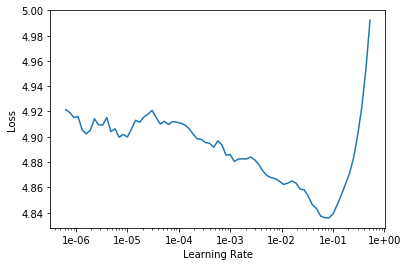

In [22]:
learn.recorder.plot(skip_end=15)

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [24]:
learn.save('fit_head')

In [25]:
learn.load('fit_head');

以完成
To complete the fine-tuning, we can then unfeeze and launch a new training.

In [26]:
learn.unfreeze()

In [27]:
# commented out because the training time didn't fit in a single Kernel session
# learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [28]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [29]:
learn.load('fine_tuned');

In [30]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [31]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because i liked the fact that the show was a good fantasy movie without being funny and funny . i love the Characters ' depravity , but i 'm not a poop fan , and i am a bit more
i liked this movie because i was a fan of ' Down Syndrome ' , but i did n't really think it was like most of the movie ( so i was just bored by the editing ) . But i was


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [32]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [33]:
path = untar_data(URLs.IMDB)

In [34]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

Exception: [Errno 21] Is a directory: '/tmp/.fastai/data/imdb/tmp_clas'
 Can't write in /tmp/.fastai/data/imdb/tmp_clas. Pass a full libpath path that is writable as `fname`.

In [35]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [36]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj okay , so i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games",neg
"xxbos xxmaj one of the most important artistic movements in the history of cinema was without a doubt xxmaj german expressionism , the highly atmospheric style of film - making developed during the 20s in xxmaj berlin . xxmaj classic movies like "" xxmaj das xxmaj cabinet xxmaj des xxmaj dr. xxmaj caligari . "" ( 1920 ) and "" xxmaj nosferatu , xxmaj eine xxmaj xxunk xxmaj des xxmaj",pos
"xxbos i 'm going to write about this movie and about "" xxmaj irreversible "" ( the ( xxunk scene in it ) . xxmaj so you are warned , if you have n't seen the movie yet . xxmaj this are just my thoughts , why i think the movie fails ( in the end - pun intended ) . \n\n xxmaj acting wise , xxmaj rosario xxmaj dawson",neg
"xxbos xxmaj obviously , i did n't care for xxmaj things to xxmaj come ( aka "" xxmaj the xxmaj shape of xxmaj things to xxmaj come "" ) as much as most viewers . xxmaj that means that there is a good chance that you 'll enjoy it more than i did . xxmaj at any rate , you might find it useful to hear the film described from",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [37]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

TypeError: text_classifier_learner() missing 1 required positional argument: 'arch'

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


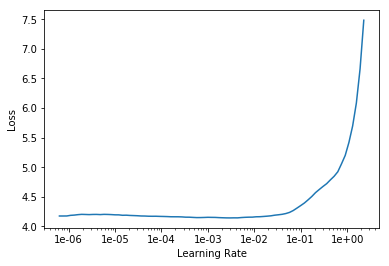

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [41]:
learn.save('first')

In [42]:
learn.load('first');

In [43]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [44]:
learn.save('second')

In [45]:
learn.load('second');

In [46]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [47]:
learn.save('third')

In [48]:
learn.load('third');

In [49]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [50]:
learn.predict("I really loved that movie, it was awesome!")

'I really loved that movie, it was awesome! i'